# Group Members (Group 1, T01)


2.Shin Than Thar Aung (7903042)





# Install PySpark


In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=4c5d272790ab0b9088de4226ad76eb067e97f9eaddfc21117e601b0589ff520e
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean as _mean
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, PolynomialExpansion
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Step 1: Initialize Spark session
spark = SparkSession.builder \
    .appName("Superconductivity Prediction")\
    .config("spark.driver.memory", "4g")\
    .config("spark.executor.memory", "4g")\
    .config("spark.sql.execution.arrow.enabled", "true")\
    .getOrCreate()

# Load data
data = spark.read.csv('/content/sample_data/train.csv', header=True, inferSchema=True)

# Data Preparation

**Data Cleaning**
Missing values are handled by calculating the mean for columns with missing data. The mean is then used to fill the missing values, except for the target variable (critical_temp). This prevents data loss while maintaining consistency.

**Feature Engineering and Scaling**
- VectorAssembler: Combines multiple columns (features) into a single feature vector, excluding the target column (critical_temp).
- StandardScaler: Normalizes features by removing the mean and scaling to unit variance, improving model performance, especially for algorithms sensitive to feature magnitude.

**Train-Test Split**
The dataset is split into 80% training data and 20% test data using random sampling. The seed=42 ensures reproducibility of the split





In [ ]:
# 2. Data preparation

# 2a. Handle missing values - calculate mean only for columns with missing values
means = {}
for col in data.columns:
    if col != 'critical_temp' and data.select(col).filter(data[col].isNull()).count() > 0:
        means[col] = data.select(_mean(col)).first()[0]

# Fill missing values with the calculated means
data = data.na.fill(means)

# Feature engineering, scaling, and splitting the data
assembler = VectorAssembler(inputCols=data.columns[:-1], outputCol="features")
data_prepared = assembler.transform(data).select("features", "critical_temp")

# Scaling features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
data_scaled = scaler.fit(data_prepared).transform(data_prepared).select("scaled_features", "critical_temp")

# Train-test split
train_data, test_data = data_scaled.randomSplit([0.8, 0.2], seed=42)

# Model Training

**linear regression model** : trained using the scaled features to predict the target variable (critical_temp).

**polynomial regression model** : A polynomial transformation is applied to the features to account for non-linear relationships. The degree is set to 2, creating quadratic feature combinations. A linear regression model is then trained on these polynomial features

**random forest regrssion moel** : A Random Forest Regressor, which is an ensemble method based on decision trees, is trained using the scaled features

In [ ]:
# Linear Regression
lr = LinearRegression(featuresCol="scaled_features", labelCol="critical_temp")
lr_model = lr.fit(train_data)

# Polynomial Regression (using feature transformations)
polyExpansion = PolynomialExpansion(degree=2, inputCol="scaled_features", outputCol="poly_features")
train_data_poly = polyExpansion.transform(train_data)
test_data_poly = polyExpansion.transform(test_data)

lr_poly = LinearRegression(featuresCol="poly_features", labelCol="critical_temp")
lr_poly_model = lr_poly.fit(train_data_poly)

# Random Forest
rf = RandomForestRegressor(featuresCol="scaled_features", labelCol="critical_temp")
rf_model = rf.fit(train_data)

# Hyperparameter Tuning with Cross-Validation

1. Tuning Linear Regression - A CrossValidator is used for hyperparameter tuning. The grid search evaluates different combinations of regularization parameters (regParam) and the Elastic Net mixing parameter (elasticNetParam). 3-fold cross-validation is performed to evaluate model performance across different splits.

In [ ]:
# 1. Fine-Tuning Linear Regression
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5]) \
    .build()

crossval_lr = CrossValidator(estimator=lr,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=RegressionEvaluator(labelCol="critical_temp"),
                             numFolds=3,  # Reduced from 5 to 3
                             parallelism=3)  # Set parallelism if possible

cv_model_lr = crossval_lr.fit(train_data)

2. Tuning polynomial regression : The same grid search approach is applied to the polynomial regression model using the polynomial features. This allows fine-tuning of the model’s regularization parameters

In [ ]:
# 2. Fine-Tuning Polynomial Regression
paramGrid_lr_poly = ParamGridBuilder() \
    .addGrid(lr_poly.regParam, [0.01, 0.1]) \
    .addGrid(lr_poly.elasticNetParam, [0.0, 0.5]) \
    .build()

crossval_lr_poly = CrossValidator(estimator=lr_poly,
                                  estimatorParamMaps=paramGrid_lr_poly,
                                  evaluator=RegressionEvaluator(labelCol="critical_temp"),
                                  numFolds=3,  # Reduced from 5 to 3
                                  parallelism=3)  # Set parallelism if possible

cv_model_lr_poly = crossval_lr_poly.fit(train_data_poly)

3. Tuning Random Forest : A cross-validation grid search is used to tune the number of trees (numTrees) and the maximum depth of each tree (maxDepth) in the Random Forest Regressor. This helps to avoid overfitting or underfitting.

In [ ]:
# 3. Fine-Tuning Random Forest
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
    .addGrid(rf.maxBins, [32, 64]) \
    .build()

crossval_rf = CrossValidator(estimator=rf,
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=RegressionEvaluator(labelCol="critical_temp"),
                             numFolds=3,  # Reduced from 5 to 3
                             parallelism=4)  # Set parallelism if possible

cv_model_rf = crossval_rf.fit(train_data)

# Model Evaluation

We will use two metrics to evaluate the three model performance.

**RMSE (Root Mean Squared Error)**: Measures the average prediction error in the same units as the target variable. Lower values indicate better model performance.

R**2(R-squared)**: Indicates the proportion of variance in the target variable explained by the model. Values closer to 1 mean the model explains more variance.

1. We will first evaluate the three model before tuning

In [ ]:
#Evaluation of Model Before Tuning
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluator for regression models
evaluator = RegressionEvaluator(labelCol="critical_temp", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="critical_temp", predictionCol="prediction", metricName="r2")


# Fit Linear Regression model before tuning
predictions_lr_before = lr_model.transform(test_data)
rmse_lr_before = evaluator.evaluate(predictions_lr_before)
r2_lr_before = evaluator_r2.evaluate(predictions_lr_before)

# Fit Polynomial Regression model before tuning
predictions_lr_poly_before = lr_poly_model.transform(test_data_poly)
rmse_lr_poly_before = evaluator.evaluate(predictions_lr_poly_before)
r2_lr_poly_before = evaluator_r2.evaluate(predictions_lr_poly_before)

# Fit Random Forest model before tuning
predictions_rf_before = rf_model.transform(test_data)
rmse_rf_before = evaluator.evaluate(predictions_rf_before)
r2_rf_before = evaluator_r2.evaluate(predictions_rf_before)

results = pd.DataFrame({
    'Model': ['Linear Regression', 'Polynomial Regression', 'Random Forest'],
    'RMSE (Before Tuning)': [rmse_lr_before, rmse_lr_poly_before, rmse_rf_before],
    'R2 (Before Tuning)': [r2_lr_before, r2_lr_poly_before, r2_rf_before]
})

print(results)

                   Model  RMSE (Before Tuning)  R2 (Before Tuning)
0      Linear Regression             17.927170            0.723207
1  Polynomial Regression             19.726804            0.664846
2          Random Forest             15.810519            0.784710


Result Interpretation

Linear Regression: Shows moderate performance with RMSE of 17.93 and R2 of 0.72.

Polynomial Regression: Has higher RMSE (19.73) and lower R2 (0.66), indicating worse performance compared to the others.

Random Forest: Performs best with the lowest RMSE (15.81) and highest R2(0.78) among the models before tuning

2. Then We will evaluate the performance after tuning

In [ ]:
# Evaluate the models' performance (After Tuning)

# Evaluate Linear Regression
predictions_lr = cv_model_lr.transform(test_data)
rmse_lr = evaluator.evaluate(predictions_lr)
r2_lr = evaluator_r2.evaluate(predictions_lr)


# Evaluate Polynomial Regression
predictions_lr_poly = cv_model_lr_poly.transform(test_data_poly)
rmse_lr_poly = evaluator.evaluate(predictions_lr_poly)
r2_lr_poly = evaluator_r2.evaluate(predictions_lr_poly)


# Evaluate Random Forest
predictions_rf = cv_model_rf.transform(test_data)
rmse_rf = evaluator.evaluate(predictions_rf)
r2_rf = evaluator_r2.evaluate(predictions_rf)


results = pd.DataFrame({
    'Model': ['Linear Regression', 'Polynomial Regression', 'Random Forest'],
    'RMSE (After Tuning)': [rmse_lr, rmse_lr_poly, rmse_rf],
    'R2 (After Tuning)': [r2_lr, r2_lr_poly, r2_rf]
})

print(results)


                   Model  RMSE (After Tuning)  R2 (After Tuning)
0      Linear Regression            17.919789           0.723435
1  Polynomial Regression            13.750952           0.837147
2          Random Forest            11.282088           0.890375


**Result Interpretation After Tuning**

Linear Regression: Slight improvement in RMSE (17.92) and R2(0.72) after tuning.

Polynomial Regression: Significant improvement with RMSE of 13.75 and R2 of 0.84, showing better performance after tuning.

Random Forest: Shows the best results with RMSE of 11.28 and R2 of 0.89 after tuning, indicating the highest performance improvements.

# Visualization of Model Performance Using Graph

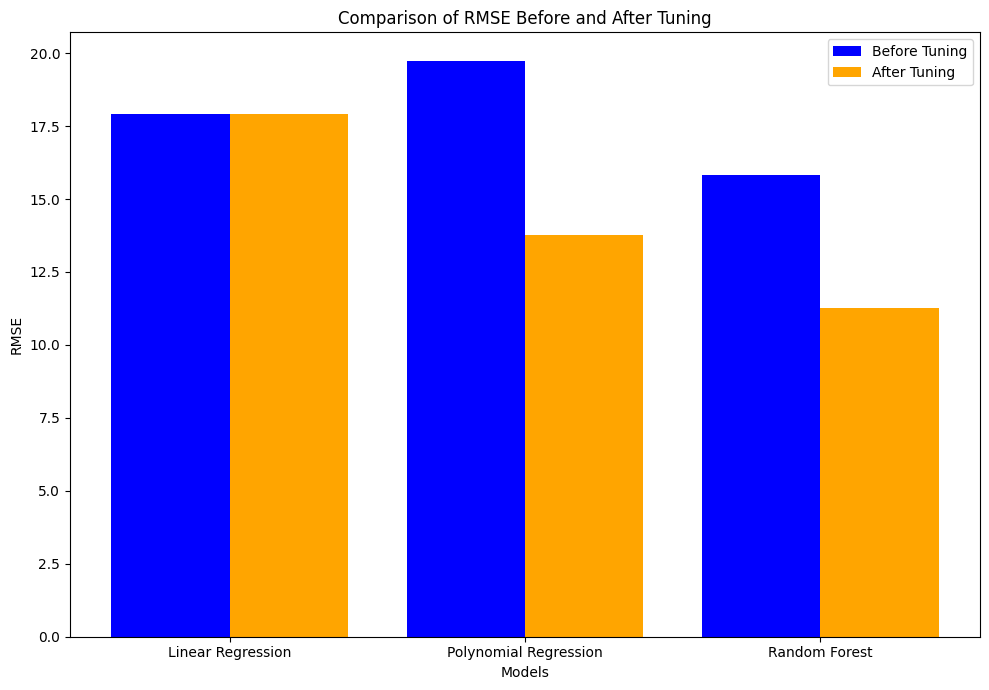

In [ ]:
import matplotlib.pyplot as plt

# RMSE values before and after tuning
rmse_values_before = [rmse_lr_before, rmse_lr_poly_before, rmse_rf_before]
rmse_values_after = [rmse_lr, rmse_lr_poly, rmse_rf]

# Model names for the x-axis
models = ['Linear Regression', 'Polynomial Regression', 'Random Forest']

# Plotting the bar chart
x = range(len(models))  # positions for bars
plt.figure(figsize=(10, 7))

# Plot bars for RMSE before tuning
plt.bar(x, rmse_values_before, width=0.4, label='Before Tuning', color='blue', align='center')

# Plot bars for RMSE after tuning
plt.bar([i + 0.4 for i in x], rmse_values_after, width=0.4, label='After Tuning', color='orange', align='center')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE Before and After Tuning')
plt.xticks([i + 0.2 for i in x], models)  # Set the correct x-ticks
plt.legend()
plt.tight_layout()

# Show plot
plt.show()

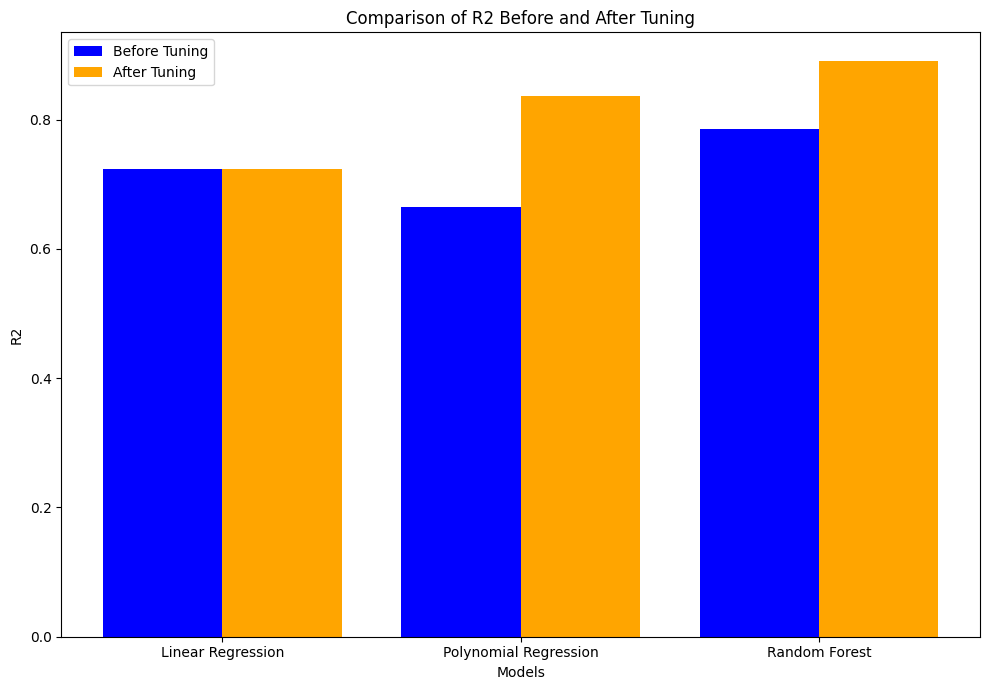

In [ ]:
import matplotlib.pyplot as plt

# r2 values before and after tuning
r2_values_before = [r2_lr_before, r2_lr_poly_before, r2_rf_before]
r2_values_after = [r2_lr, r2_lr_poly, r2_rf]

# Model names for the x-axis
models = ['Linear Regression', 'Polynomial Regression', 'Random Forest']

# Plotting the bar chart
x = range(len(models))  # positions for bars
plt.figure(figsize=(10, 7))

# Plot bars for R2 before tuning
plt.bar(x, r2_values_before, width=0.4, label='Before Tuning', color='blue', align='center')

# Plot bars for R2 after tuning
plt.bar([i + 0.4 for i in x], r2_values_after, width=0.4, label='After Tuning', color='orange', align='center')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('R2')
plt.title('Comparison of R2 Before and After Tuning')
plt.xticks([i + 0.2 for i in x], models)  # Set the correct x-ticks
plt.legend()
plt.tight_layout()

# Show plot
plt.show()

# Final Analysis:

Random Forest consistently performs the best in both RMSE and R2 metrics, showing it is the most accurate and reliable model for this data.

Polynomial Regression improved the most after tuning, closing the gap with Random Forest but still underperforming slightly in RMSE.

Linear Regression showed minimal improvement, indicating its performance is relatively stable with the current tuning adjustments.